In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_health = pd.read_csv("./체질검사.CSV",engine="python")
ds_health.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


# 1. 데이터 정제 - 이상치
**1.0 각각의 Data에 대해 Boxplot을 그려서 이상치 여부를 확인했다.**<br>

**1.1 weight가 350파운드 이상 되는 사람의 지표를 찾아보니 모든 변수가 다 커서 이상치제거를 하지 않도록했다.**<br>

**1.2 또 키가 50inch이하인 사람에 대해서 분석해봤는데 이 데이터는 이상치라고 판단해서 제거하기로했다.**<br>

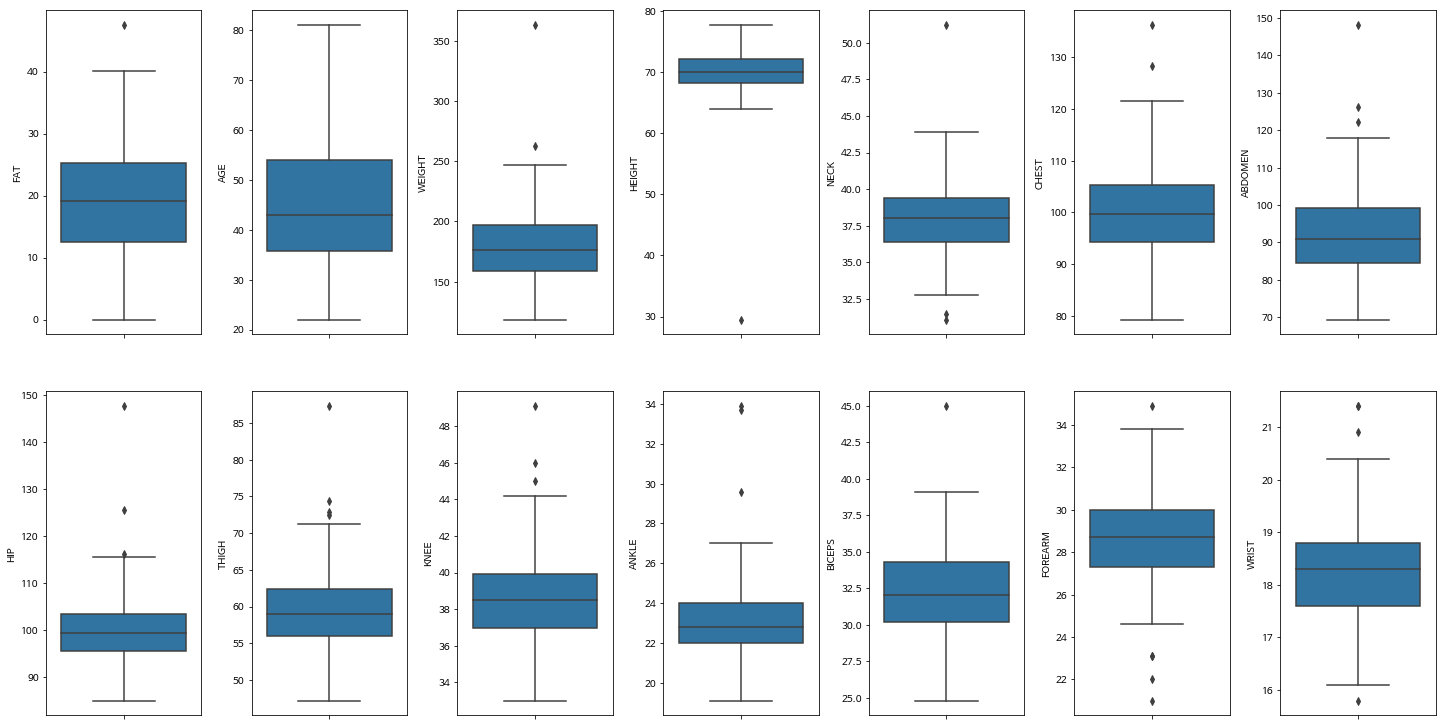

In [2]:
# 이상치 확인
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in ds_health.items():
    sns.boxplot(y=k, data=ds_health, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# 1. 데이터 정제 - 78번 데이터 삭제
**1.3 78번 데이터가 삭제된 것을 boxplot으로 확인**

     FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  \
78  32.9   44   205.0    29.5  36.6  106.0    104.3  115.5   70.6  42.5   

    ANKLE  BICEPS  FOREARM  WRIST  
78   23.7    33.6     28.7   17.4  


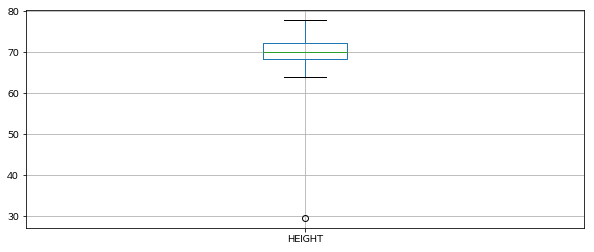

In [3]:
ds_health[['HEIGHT']].boxplot(figsize=(10,4))
print(ds_health.loc[ds_health.HEIGHT<40,:])
ds_health =ds_health.drop(78,0)

# 1. 분석에 필요한 데이터 구성하기

In [4]:
# 목표변수, 설명변수 역할 지정
ds_health_y = ds_health["FAT"]
ds_health_x= ds_health.drop("FAT",axis=1,inplace =False)

print("목표변수 데이터 크기: {}".format(ds_health_y.shape))
print("설명변수 데이터 크기: {}",format(ds_health_x.shape))

목표변수 데이터 크기: (251,)
설명변수 데이터 크기: {} (251, 13)


In [5]:
# 절편 추가
ds_health_x_const = sm.add_constant(ds_health_x)
ds_health_x_const.head()

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,1.0,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


# 2. 변수 간의 경향성 파악 - 그래프 분석
- **변수간의 산점도 확인을 통해 변수간의 경향성을 확인**

#### 산점도 행렬
sns.pairplot(ds_health)

# 3. 변수 간의 경향성 파악 - 상관관계 분석

In [7]:
# 상관 관계 분석
ds_health.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000,0.294,0.611,-0.023,0.497,0.703,0.813,0.620,0.554,0.503,0.265,0.493,0.363,0.355
AGE,0.294,1.000,-0.013,-0.245,0.113,0.177,0.231,-0.050,-0.201,0.018,-0.105,-0.041,-0.085,0.214
WEIGHT,0.611,-0.013,1.000,0.489,0.835,0.894,0.888,0.944,0.870,0.853,0.614,0.800,0.631,0.735
HEIGHT,-0.023,-0.245,0.489,1.000,0.321,0.228,0.192,0.378,0.344,0.505,0.394,0.319,0.322,0.397
NECK,0.497,0.113,0.835,0.321,1.000,0.787,0.759,0.748,0.708,0.680,0.479,0.733,0.624,0.744
CHEST,0.703,0.177,0.894,0.228,0.787,1.000,0.916,0.833,0.732,0.720,0.483,0.728,0.581,0.664
ABDOMEN,0.813,0.231,0.888,0.192,0.759,0.916,1.000,0.875,0.766,0.736,0.453,0.685,0.504,0.626
HIP,0.620,-0.050,0.944,0.378,0.748,0.833,0.875,1.000,0.894,0.821,0.561,0.743,0.550,0.645
THIGH,0.554,-0.201,0.870,0.344,0.708,0.732,0.766,0.894,1.000,0.797,0.542,0.765,0.572,0.572
KNEE,0.503,0.018,0.853,0.505,0.680,0.720,0.736,0.821,0.797,1.000,0.613,0.680,0.559,0.675


# 회귀분석 실시
- **R-Square값은 높게 측정됐다.**
- **변수의 p-val에서 HEIGHT, KNEE변수등의 부족함이 보였다.**
- **또한 Jarque-Bera값을 볼때 이 회귀분석의잔차는 정규성을 띈다고 보기 어렵다고 생각했다.**

In [8]:
# 회귀 모델 생성
reg_multi_model = sm.OLS(ds_health_y, ds_health_x_const)
# 적합
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     53.64
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           5.28e-63
Time:                        23:06:31   Log-Likelihood:                -715.89
No. Observations:                 251   AIC:                             1460.
Df Residuals:                     237   BIC:                             1509.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.4923     22.244     -0.921      0.3

# 3. 회귀 모델 생성 : 전체 설명변수 대상으로 다중 공선성 검토

1. 다중공선성이 WEIGHT가 가장 큰 것을 확인

In [9]:
# 데이터 테이블 생성 -> 값 입력
ds_vif = pd.DataFrame()
# 변수 명 입력
ds_vif["variable"] = ds_health_x_const.columns
# variance_inflation_factor 다중공선성 함수, exog : 설명변수 데이터, exog_idx : 변수 인덱스
ds_vif["vif"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]
# VIF 낮은 순 정렬
ds_vif.sort_values("vif",inplace = True)
ds_vif.round(3)

,variable,vif
10,ANKLE,1.923
12,FOREARM,2.194
1,AGE,2.251
3,HEIGHT,2.938
13,WRIST,3.368
11,BICEPS,3.670
4,NECK,4.448
9,KNEE,4.783
8,THIGH,7.863
5,CHEST,10.227


# 4. 후진제거법을 이용한 변수 선택
1. 작은 variables변수 선택

In [10]:
# RFE(recursive feature elimination) 함수: 입력된 모델을 이용해 변수중요도가 낮은 순으로 순차적 제거
# sklearn의 선형회귀 모델
model = LinearRegression()
# 전체의 변수 중 5개의 변수가 남을 때까지 변수 제거
rfe = RFE(estimator = model, n_features_to_select = 5).fit(ds_health_x,ds_health_y)
# 선택된 변수
selected_cols = ds_health_x.columns[rfe.support_]
# 제거된 변수
removed_cosl = ds_health_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols))
print("Removed Variables : {}".format(removed_cosl))

Selected Variables : Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


# 4.후진제거법을 이용한 변수 선택 - 회귀 모델 선택
- **후진제거법으로 모델을 구동했다**
- **변수들의 p-val값이 전체적으로 작아졌다.**
- **NECK, HEIGHT 변수를 제외한 모든 변수의 베타 값이 유의하다는 결과가 나왔다.**
- **전체적으로 R-Square값도 떨어지고, 이 모델을 선택해야 할 만큼의 설명력을 얻지 못했다.**

In [11]:
# 후진제거법에의해 선택된 데이터
ds_health_x_rfe = sm.add_constant(ds_health_x_const[selected_cols])
# 회귀 모델 생성
reg_multi_rfe_model = sm.OLS(ds_health_y, ds_health_x_rfe)
# 적합
reg_multi_rfe_results = reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           1.45e-67
Time:                        23:06:38   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5851      6.224      0.415      0.6

# 4. 후진제거법을 이용한 변수 선택 - 선정된 설명변수 대상으로 다중 공선성 진단
1. **변수 제거법을 이용해 선택된 변수들 간에는 다중공선성의 문제 없음** <br>

In [12]:
# 후진제거법에 의해 선택된 데이터
ds_rfe_vif = pd.DataFrame()
ds_rfe_vif["variable"] = ds_health_x_rfe.columns
ds_rfe_vif["vif"] = [variance_inflation_factor(ds_health_x_rfe.values,i)for i in range(ds_health_x_rfe.shape[1])]
ds_rfe_vif.sort_values("vif",inplace = True)
ds_rfe_vif.round(3)

,variable,vif
4,FOREARM,1.769
5,WRIST,2.443
1,NECK,3.602
3,HIP,4.778
2,ABDOMEN,4.803
0,const,507.331


# 후진제거법 이후 β값 - not noramalization
**목표변수를 설명하는데 WRIST와 ABDOMEN 이 가장 큰 값으로 나타나 가장 중요한 변수로 보인다고 했는데 후진제거법 후에도 WRIST와 ABDOMEN의 변수가 목표변수를 설명하는데 가장 중요도가 높다고 말할 수 있다.** 

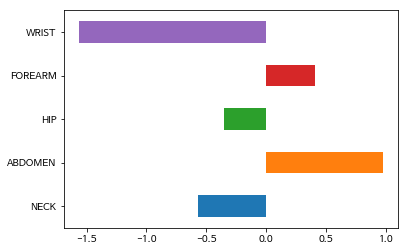

In [13]:
ds_reg_ref_scaled_coef = pd.DataFrame({"Coef" : reg_multi_rfe_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_ref_scaled_coef.plot.barh(y="Coef",legend=False)

# 후진제거법 이후 β값 - noramalization
**목표변수를 설명하는데 WRIST랑 ABDONMEN이 가장 중요한 variable이라 생각했다. 하지만 normalization을 하고 난 후 HIP과 ABDOMEN이 목표변수를 설명하는데 가장 중요한 variable이라고 말할 수 있다.**

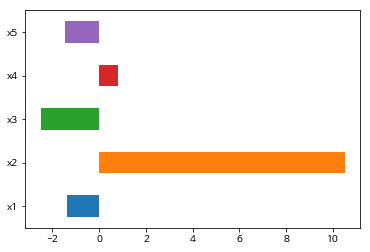

In [14]:
ds_health_x_scale = scale(ds_health_x_const[selected_cols])
ds_health_x_scale = sm.add_constant(ds_health_x_scale)
# 회귀 모델 생성
reg_multi_rfe_model = sm.OLS(ds_health_y,ds_health_x_scale)
# 적합
reg_multi_rfe_results = reg_multi_rfe_model.fit()
# 설명변수 중요도
ds_reg_ref_scaled_coef = pd.DataFrame({"Coef" : reg_multi_rfe_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_ref_scaled_coef.plot.barh(y="Coef",legend=False)

## 새로운 파생변수 **BMI**고려

In [15]:
ds_health['BMI'] = ds_health['WEIGHT']*0.45 / (ds_health['HEIGHT']*2.54/100)**2
ds_health.head().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.524
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.083
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.839
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293


# describe 사용해 BMI의 주요값 확인

In [16]:
ds_health['BMI'].describe()

count    251.000000
mean      25.184691
std        3.629053
min       17.874982
25%       22.853241
50%       24.883289
75%       27.098349
max       48.523870
Name: BMI, dtype: float64

# 이상치 확인
Height를 제거 해서 BMI중 이상치 제거 안해도 될거 같음

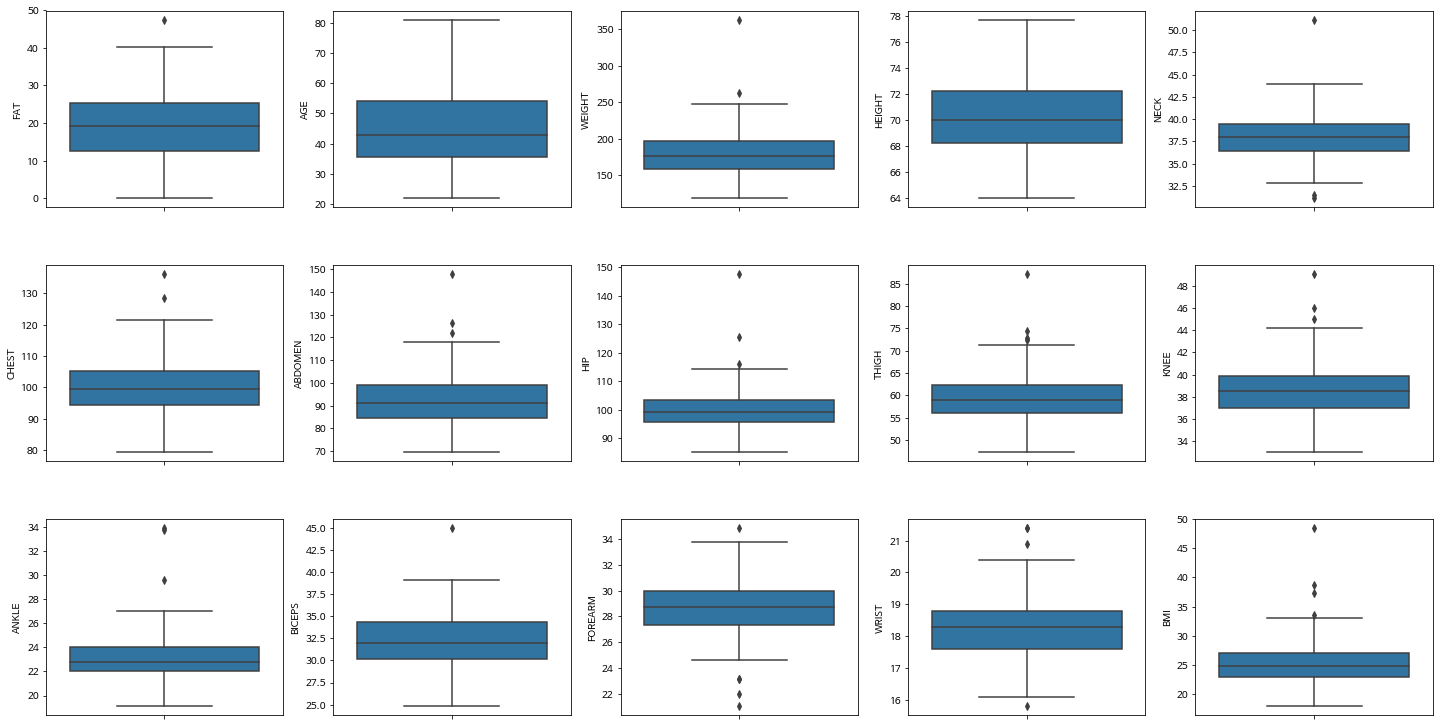

In [17]:
# 이상치 확인
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in ds_health.items():
    sns.boxplot(y=k, data=ds_health, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# 데이터 정제 - 78번 데이터 확인

Empty DataFrame
Columns: [FAT, AGE, WEIGHT, HEIGHT, NECK, CHEST, ABDOMEN, HIP, THIGH, KNEE, ANKLE, BICEPS, FOREARM, WRIST, BMI]
Index: []


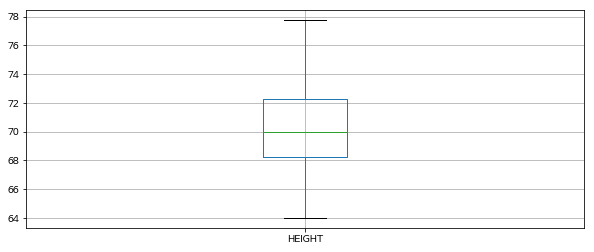

In [18]:
ds_health[['HEIGHT']].boxplot(figsize=(10,4))
print(ds_health.loc[ds_health.HEIGHT<40,:])

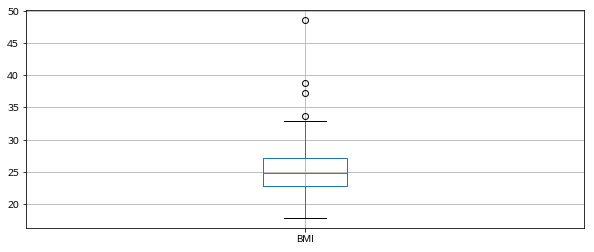

In [19]:
ds_health[['BMI']].boxplot(figsize=(10,4))
#ds_health =ds_health.drop(45,0)

# 분석에 필요한 데이터 구성하기
**bmi 추가한 것을 확인**

In [20]:
# 목표변수, 설명변수 역할 지정
ds_health_x= ds_health.drop("FAT",axis=1,inplace =False)
ds_health_y=ds_health['FAT']
print(ds_health.head())
print("목표변수 데이터 크기: {}".format(ds_health_y.shape))
print("설명변수 데이터 크기: {}",format(ds_health_x.shape))

    FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST        BMI  
0    45.0     29.0   21.4  48.523870  
1    29.0     30.0   18.8  23.082595  
2    30.8     25.7   18.8  26.422478  
3    31.7     27.3   16.9  23.838617  
4    34.7     29.1   18.4  37.293165  
목표변수 데이터 크기: (251,)
설명변수 데이터 크기: {} (251, 14)


In [21]:
# 절편 추가
ds_health_x_const = sm.add_constant(ds_health_x)
ds_health_x_const.head()

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,1.0,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,1.0,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


# 변수 간의 경향성 파악 - 상관관계 분석

In [22]:
# 상관 관계 분석
ds_health_x_const.corr().round(3)

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,NaN,1.000,-0.013,-0.245,0.113,0.177,0.231,-0.050,-0.201,0.018,-0.105,-0.041,-0.085,0.214,0.115
WEIGHT,NaN,-0.013,1.000,0.489,0.835,0.894,0.888,0.944,0.870,0.853,0.614,0.800,0.631,0.735,0.888
HEIGHT,NaN,-0.245,0.489,1.000,0.321,0.228,0.192,0.378,0.344,0.505,0.394,0.319,0.322,0.397,0.039
NECK,NaN,0.113,0.835,0.321,1.000,0.787,0.759,0.748,0.708,0.680,0.479,0.733,0.624,0.744,0.785
CHEST,NaN,0.177,0.894,0.228,0.787,1.000,0.916,0.833,0.732,0.720,0.483,0.728,0.581,0.664,0.910
ABDOMEN,NaN,0.231,0.888,0.192,0.759,0.916,1.000,0.875,0.766,0.736,0.453,0.685,0.504,0.626,0.922
HIP,NaN,-0.050,0.944,0.378,0.748,0.833,0.875,1.000,0.894,0.821,0.561,0.743,0.550,0.645,0.885
THIGH,NaN,-0.201,0.870,0.344,0.708,0.732,0.766,0.894,1.000,0.797,0.542,0.765,0.572,0.572,0.814
KNEE,NaN,0.018,0.853,0.505,0.680,0.720,0.736,0.821,0.797,1.000,0.613,0.680,0.559,0.675,0.709


# 회귀 모델 생성
# -> 전체 모형에 대한 평판을 알아보자
p값이 유의수준보다 작으므로 모델이 유의하다. 또한 Adj R-squared(다중회귀)는 0.739로 설명변수들이 목표변수를 73.9% 정도로 설명할 수 있음을 나타낸다

In [23]:
# 회귀 모델 생성
reg_model = sm.OLS(ds_health_y, ds_health_x_const)
# 적합
reg_results = reg_model.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     51.59
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           1.29e-63
Time:                        23:06:51   Log-Likelihood:                -712.18
No. Observations:                 251   AIC:                             1454.
Df Residuals:                     236   BIC:                             1507.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -148.1387     52.793     -2.806      0.0

# 3. 회귀 모델 생성 : 전체 설명변수 대상으로 다중 공선성 검토

1. 다중공선성이 WEIGHT, BMI가 가장 큰 것을 확인
2. 파생변수 BMI를 추가한 후에도 CHEST, NECK, HIP 등 유의하지 않은 변수들이 존재하므로 변수 제거를 고려해보도록 하자

In [24]:
# 데이터 테이블 생성 -> 값 입력
ds_vif = pd.DataFrame()
# 변수 명 입력
ds_vif["variable"] = ds_health_x_const.columns
# variance_inflation_factor 다중공선성 함수, exog : 설명변수 데이터, exog_idx : 변수 인덱스
ds_vif["vif"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]
# VIF 낮은 순 정렬
ds_vif.sort_values("vif",inplace = True)
ds_vif.round(3)

,variable,vif
10,ANKLE,1.941
12,FOREARM,2.259
1,AGE,2.270
13,WRIST,3.389
11,BICEPS,3.671
4,NECK,4.451
9,KNEE,4.863
8,THIGH,7.864
5,CHEST,10.759
6,ABDOMEN,13.406


# WEIGHT의 VIF가 매우 큰 값을 가지므로 WEIGHT의 variable를 제거하여 본다

In [29]:
# 데이터 테이블 생성 -> 값 입력
ds_vif = pd.DataFrame()
df_vif = ds_health_x_const.drop(['WEIGHT'], axis=1, inplace=False)
ds_vif['variable'] = df_vif.columns
ds_vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
ds_vif.sort_values('VIF', inplace = True)
ds_vif.round(3)

,variable,VIF
9,ANKLE,1.941
11,FOREARM,2.204
1,AGE,2.270
12,WRIST,3.388
10,BICEPS,3.632
3,NECK,4.332
8,KNEE,4.737
2,HEIGHT,5.852
7,THIGH,7.829
4,CHEST,10.759


In [37]:
ds_health_x_const = ds_health_x_const.drop('WEIGHT',1)

# 4. 후진제거법을 이용한 변수 선택
1. 작은 variables변수 선택

In [38]:
# RFE(recursive feature elimination) 함수: 입력된 모델을 이용해 변수중요도가 낮은 순으로 순차적 제거
# sklearn의 선형회귀 모델
model = LinearRegression()
# 전체의 변수 중 5개의 변수가 남을 때까지 변수 제거
rfe = RFE(estimator = model, n_features_to_select = 5).fit(ds_health_x_const,ds_health_y)
# 선택된 변수
selected_add_cols = ds_health_x_const.columns[rfe.support_]
# 제거된 변수
removed_add_cosl = ds_health_x_const.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_add_cols))
print("Removed Variables : {}".format(removed_add_cosl))

Selected Variables : Index(['HEIGHT', 'ABDOMEN', 'FOREARM', 'WRIST', 'BMI'], dtype='object')
Removed Variables : Index(['const', 'AGE', 'NECK', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS'],
      dtype='object')


# 다중 회귀
- 다중 회귀 이므로 Adj. R-squared 값을 확인해야한다.
- 0.723이므로 72.3%의 설명력을 갖고있다.
이 의미는 HEIGHT ABDOMEN FOREARM  WRIST BMI이 72.3%만큼 FAT를 설명할 수 있다는 의미이다.

In [39]:
# 후진제거법에의해 선택된 데이터
ds_health_x_rfe = sm.add_constant(ds_health_x_const[selected_add_cols])
# 회귀 모델 생성
reg_multi_rfe_model = sm.OLS(ds_health_y, ds_health_x_rfe)
# 적합
reg_multi_rfe_results = reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     131.5
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           2.68e-67
Time:                        23:13:52   Log-Likelihood:                -724.37
No. Observations:                 251   AIC:                             1461.
Df Residuals:                     245   BIC:                             1482.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1913      8.058      1.761      0.0

# 4. 후진제거법을 이용한 변수 선택 - 선정된 설명변수 대상으로 다중 공선성 진단
1. **변수 제거법을 이용해 선택된 변수들 간에는 다중공선성의 문제 없음** <br>

Weight를 제거하지 않았을 때 vif가 200정도 나왔는데<br>
weight를 제거 한 후 vif가 대부분 10이하로 나왔다.<br>

In [40]:
# 후진제거법에 의해 선택된 데이터
ds_rfe_vif = pd.DataFrame()
ds_rfe_vif["variable"] = ds_health_x_rfe.columns
ds_rfe_vif["vif"] = [variance_inflation_factor(ds_health_x_rfe.values,i)for i in range(ds_health_x_rfe.shape[1])]
ds_rfe_vif.sort_values("vif",inplace = True)
ds_rfe_vif.round(3)

,variable,vif
1,HEIGHT,1.679
3,FOREARM,1.849
4,WRIST,2.304
2,ABDOMEN,8.343
5,BMI,10.069
0,const,846.002


# 후진제거법 이후 β값 - not noramalization
**목표변수를 설명하는데 WRIST와 ABDOMEN 이 가장 큰 값으로 나타나 가장 중요한 변수로 보인다고 했는데 후진제거법 후에도 WRIST와 ABDOMEN의 변수가 목표변수를 설명하는데 가장 중요도가 높다고 말할 수 있다.** 

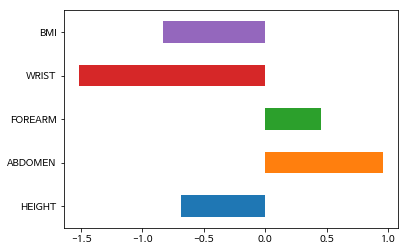

In [41]:
ds_reg_coef = pd.DataFrame({"Coef" : reg_multi_rfe_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_coef.plot.barh(y="Coef",legend=False)

# 후진제거법 이후 β값 - noramalization
**목표변수를 설명하는데 WRIST랑 ABDONMEN이 가장 중요한 variable이라 생각했다. 하지만 normalization을 하고 난 후 FOREAM과 ABDOMEN이 목표변수를 설명하는데 가장 중요한 variable이라고 말할 수 있다.**

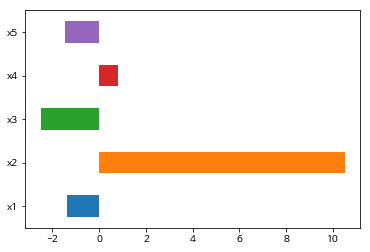

In [42]:
ds_add_health_x_scale = scale(ds_health_x_const[selected_cols])
ds_add_health_x_scale = sm.add_constant(ds_add_health_x_scale)
# 회귀 모델 생성
reg_add_multi_rfe_model = sm.OLS(ds_health_y,ds_add_health_x_scale)
# 적합
reg_add_multi_rfe_results = reg_add_multi_rfe_model.fit()
# 설명변수 중요도
ds_add_reg_ref_scaled_coef = pd.DataFrame({"Coef" : reg_add_multi_rfe_results.params.values[1:]},index=reg_add_multi_rfe_model.exog_names[1:])
ds_add_reg_ref_scaled_coef.plot.barh(y="Coef",legend=False)